In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score
from tpot import TPOTClassifier
import matplotlib.pyplot as plt

In [2]:
# Load pd_train
pd_train = pd.read_parquet("data/training_class.parquet")
pd_train["label"] = pd_train["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)

(1241, 16094)


In [3]:
# Load pd_test
pd_test = pd.read_parquet("data/testing_class.parquet")
pd_test["label"] = pd_test["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)

(286, 16094)


In [4]:
X_train = pd_train.drop(columns=["Class", "label"])
y_train = pd_train["label"]

X_test = pd_test.drop(columns=["Class", "label"])
y_test = pd_test["label"]

# TPOT optimization

In [5]:
# Set up TPOT with basic configuration
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring="roc_auc",  # AUC
    random_state=42,
    n_jobs=4  # Use 4 cores
)

# Fit the model
tpot.fit(X_train, y_train)

Version 0.12.1 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7492814875999718

Generation 2 - Current best internal CV score: 0.7492814875999718

Generation 3 - Current best internal CV score: 0.7492814875999718

Generation 4 - Current best internal CV score: 0.7492814875999718

Generation 5 - Current best internal CV score: 0.7492814875999718

Best pipeline: RandomForestClassifier(MinMaxScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)


TPOTClassifier(generations=5, n_jobs=4, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [6]:
# Evaluate the best model found by TPOT
y_pred = tpot.predict(X_test)
y_pred_proba = tpot.predict_proba(X_test)[:, 1]

# Print performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_pred_proba))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.8146853146853147
Log Loss: 0.47206500243926136
AUC: 0.88771319178559


# PCA optimization

In [2]:
# # Example data (replace with actual data)
# X = pd.DataFrame(np.random.randn(1000, 1600), columns=[f"feature_{i}" for i in range(1600)])
# y = np.random.randint(2, size=1000)

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Dimensions for PCA
# dimensions = [10, 20, 50]
# tpot_results = []  # List to store results

In [8]:
# List to store AUC scores for different PCA dimensions
# dimensions = range(100, 500, 100)  # Check PCA dimensions from 1 to 10
dimensions = [10, 20, 50, 100, 200, 300, 500, 800, 1000, 1200]
# dimensions = [10, 20, 50]
tpot_results = []  # List to store results

# Loop over different numbers of PCA components
for n_components in dimensions:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Set up TPOT with basic configuration
    tpot = TPOTClassifier(
        generations=5,
        population_size=20,
        verbosity=2,
        scoring="roc_auc",  # AUC
        random_state=42,
        n_jobs=12  # Use 4 cores
    )
    
    # Fit TPOT on the PCA-transformed data
    tpot.fit(X_train_pca, y_train)
    
    # Access the best pipeline directly after fitting
    best_pipeline = tpot.fitted_pipeline_

    # Check if the model has predict_proba
    if hasattr(best_pipeline, "predict_proba"):
        y_pred_proba = best_pipeline.predict_proba(X_test_pca)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        # Fallback to accuracy if predict_proba is unavailable
        y_pred = best_pipeline.predict(X_test_pca)
        auc = accuracy_score(y_test, y_pred)  # Substitute with accuracy if AUC can't be calculated
    
    
    y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

    # Extract model name and parameters
    model_name = type(best_pipeline.steps[-1][1]).__name__  # Name of the final estimator
    model_params = best_pipeline.steps[-1][1].get_params()  # Params of the final estimator
    

    # Append results to list
    result = {
        "PCA Components": n_components,
        "Model Name": model_name,
        "Parameters": model_params,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall
    }
    tpot_results.append(result)
    
    print(result)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7144354528653049

Generation 2 - Current best internal CV score: 0.7144354528653049

Generation 3 - Current best internal CV score: 0.7204036148144403

Generation 4 - Current best internal CV score: 0.7204036148144403

Generation 5 - Current best internal CV score: 0.7204036148144403

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.15000000000000002, min_samples_leaf=2, min_samples_split=4, n_estimators=100)
{'PCA Components': 10, 'Model Name': 'RandomForestClassifier', 'Parameters': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.15000000000000002, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'war

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7221484523726635

Generation 2 - Current best internal CV score: 0.7246743512703957

Generation 3 - Current best internal CV score: 0.7349261942891182

Generation 4 - Current best internal CV score: 0.7349261942891182

Generation 5 - Current best internal CV score: 0.7349261942891182

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.8, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
{'PCA Components': 20, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.8, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}, 'AUC': 0.900

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7372154162266603

Generation 2 - Current best internal CV score: 0.7372154162266603

Generation 3 - Current best internal CV score: 0.7372154162266603

Generation 4 - Current best internal CV score: 0.7386743031943493

Generation 5 - Current best internal CV score: 0.7408261518012215

Best pipeline: ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=5, min_samples_split=6, n_estimators=100)
{'PCA Components': 50, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.4, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}, 'AUC'

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.718791968972438

Generation 2 - Current best internal CV score: 0.7264699138927616

Generation 3 - Current best internal CV score: 0.7265649443837507

Generation 4 - Current best internal CV score: 0.7334744323849091

Generation 5 - Current best internal CV score: 0.7334744323849091

Best pipeline: ExtraTreesClassifier(MinMaxScaler(input_matrix), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=6, min_samples_split=9, n_estimators=100)
{'PCA Components': 100, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.35000000000000003, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.716516800730452

Generation 2 - Current best internal CV score: 0.716516800730452

Generation 3 - Current best internal CV score: 0.716516800730452

Generation 4 - Current best internal CV score: 0.7218420660086879

Generation 5 - Current best internal CV score: 0.7218420660086879

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=9, p=1, weights=distance)
{'PCA Components': 200, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}, 'AUC': 0.9141663766098155, 'Precision': 0.9269406392694064, 'Recall': 0.918552036199095}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7269598345355107

Generation 2 - Current best internal CV score: 0.7269859991984562

Generation 3 - Current best internal CV score: 0.726986073453844

Generation 4 - Current best internal CV score: 0.726986073453844

Generation 5 - Current best internal CV score: 0.7271429560924785

Best pipeline: LinearSVC(XGBClassifier(MLPClassifier(input_matrix, alpha=0.001, learning_rate_init=0.001), learning_rate=0.001, max_depth=7, min_child_weight=11, n_estimators=100, n_jobs=1, subsample=0.05, verbosity=0), C=0.0001, dual=False, loss=squared_hinge, penalty=l2, tol=0.0001)
{'PCA Components': 300, 'Model Name': 'LinearSVC', 'Parameters': {'C': 0.0001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}, 'AUC': 0.7867132867132867, 'Precision': 0.9040404040404041, 'Recall': 0.8099547511312

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7116291742579849

Generation 2 - Current best internal CV score: 0.7116291742579849

Generation 3 - Current best internal CV score: 0.716636250019341

Generation 4 - Current best internal CV score: 0.716636250019341

Generation 5 - Current best internal CV score: 0.716636250019341

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)
{'PCA Components': 500, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, 'AUC': 0.8722241559345632, 'Precision': 0.9040404040404041, 'Recall': 0.8099547511312217}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7183054342890243

Generation 2 - Current best internal CV score: 0.7183054342890243

Generation 3 - Current best internal CV score: 0.7183054342890243

Generation 4 - Current best internal CV score: 0.7274320728982065

Generation 5 - Current best internal CV score: 0.7274320728982065

Best pipeline: LogisticRegression(input_matrix, C=0.001, dual=False, penalty=l2)
{'PCA Components': 800, 'Model Name': 'LogisticRegression', 'Parameters': {'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}, 'AUC': 0.8215106160807518, 'Precision': 0.9040404040404041, 'Recall': 0.8099547511312217}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7120304041793281

Generation 2 - Current best internal CV score: 0.7120304041793281

Generation 3 - Current best internal CV score: 0.7120304041793281

Generation 4 - Current best internal CV score: 0.7138531783792627

Generation 5 - Current best internal CV score: 0.7138531783792627

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=7, p=2, weights=distance)
{'PCA Components': 1000, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}, 'AUC': 0.8990602158022972, 'Precision': 0.9040404040404041, 'Recall': 0.8099547511312217}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7023357969026041

Generation 2 - Current best internal CV score: 0.7147752813519371

Generation 3 - Current best internal CV score: 0.7156608213170849

Generation 4 - Current best internal CV score: 0.7156608213170849

Generation 5 - Current best internal CV score: 0.7156608213170849

Best pipeline: KNeighborsClassifier(GaussianNB(input_matrix), n_neighbors=3, p=2, weights=distance)
{'PCA Components': 1200, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, 'AUC': 0.8733727810650888, 'Precision': 0.9040404040404041, 'Recall': 0.8099547511312217}


In [9]:
# Convert results to DataFrame
tpot_df = pd.DataFrame(tpot_results)
tpot_df

,PCA Components,Model Name,Parameters,AUC,Precision,Recall
0,10,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.865855,0.926941,0.918552
1,20,ExtraTreesClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.900731,0.926941,0.918552
2,50,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.897668,0.926941,0.918552
3,100,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.904769,0.926941,0.918552
4,200,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.914166,0.926941,0.918552
5,300,LinearSVC,"{'C': 0.0001, 'class_weight': None, 'dual': Fa...",0.786713,0.904040,0.809955
6,500,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.872224,0.904040,0.809955
7,800,LogisticRegression,"{'C': 0.001, 'class_weight': None, 'dual': Fal...",0.821511,0.904040,0.809955
8,1000,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.899060,0.904040,0.809955
9,1200,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.873373,0.904040,0.809955


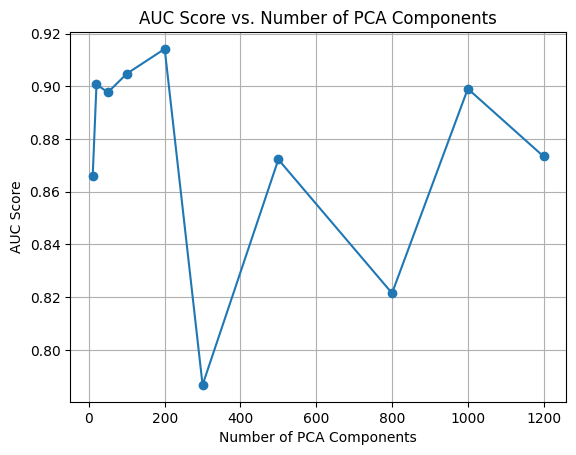

In [10]:

# Plot AUC scores against the number of PCA components
plt.plot(tpot_df["PCA Components"], tpot_df["AUC"], marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. Number of PCA Components')
plt.grid()
plt.show()